<a href="https://colab.research.google.com/github/jinkyukim-me/Pytorch_Class_/blob/master/Aadvance_CNN(VGG_cifar10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-5 VGG for cifar10

## original code is =>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [0]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [0]:
# import visdom

# vis = visdom.Visdom()
# vis.close(env="main")

## define loss tracker

In [0]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# # functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# vis.images(images/2 + 0.5)

# # show images
# #imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## make VGG16 using vgg.py

In [0]:
# import vgg
import torchvision.models.vgg as vgg

In [0]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [0]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [0]:
vgg16= VGG(vgg.make_layers(cfg),10,True).to(device)

In [24]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[ 3.7634e+35,  2.4934e+35, -5.2164e+35, -1.7491e+35,  2.7326e+35,
          8.1588e+34,  6.1067e+35,  2.8271e+35,  4.4875e+35, -8.5873e+34]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005,momentum=0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

## make plot

In [0]:
# loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

## training

In [27]:
print(len(trainloader))
epochs = 50

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        

print('Finished Training')

98
[1,    30] loss: 2.302
[1,    60] loss: 2.297
[1,    90] loss: 2.276
[2,    30] loss: 2.173
[2,    60] loss: 2.083
[2,    90] loss: 1.994
[3,    30] loss: 1.880
[3,    60] loss: 1.795
[3,    90] loss: 1.710
[4,    30] loss: 1.650
[4,    60] loss: 1.609
[4,    90] loss: 1.564
[5,    30] loss: 1.506
[5,    60] loss: 1.473
[5,    90] loss: 1.410
[6,    30] loss: 1.388
[6,    60] loss: 1.364
[6,    90] loss: 1.354
[7,    30] loss: 1.290
[7,    60] loss: 1.250
[7,    90] loss: 1.243
[8,    30] loss: 1.256
[8,    60] loss: 1.215
[8,    90] loss: 1.156
[9,    30] loss: 1.128
[9,    60] loss: 1.119
[9,    90] loss: 1.100
[10,    30] loss: 1.026
[10,    60] loss: 1.027
[10,    90] loss: 1.014
[11,    30] loss: 0.966
[11,    60] loss: 0.961
[11,    90] loss: 0.962
[12,    30] loss: 0.924
[12,    60] loss: 0.905
[12,    90] loss: 0.926
[13,    30] loss: 0.861
[13,    60] loss: 0.870
[13,    90] loss: 0.875
[14,    30] loss: 0.804
[14,    60] loss: 0.824
[14,    90] loss: 0.830
[15,    30] loss

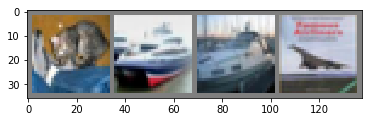

GroundTruth:    cat  ship  ship plane


In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = vgg16(images.to(device))

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [31]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %
